##Preprocesado de datos

In [1]:
import pandas as pd
from pandas_datareader import data
from pandas_datareader._utils import RemoteDataError
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta
import yfinance as yf

In [2]:
#extracción de datos de entrenamiento
start_date = (datetime.now()-timedelta(50)).strftime('2021-07-1')
end_date = datetime.now().strftime('2023-07-30')
key = 'MSFT'

def get_data(ticker):
  try:
    tickerData = yf.Ticker(key)
    stock_data = tickerData.history(period='1d', start=start_date, end=end_date)
  except RemoteDataError:
    print('No data found for {t}'.format(t=ticker))
  return stock_data


In [3]:
train_set = get_data(key)
train_set.shape

(522, 7)

In [4]:
train_set.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2021-07-01 00:00:00-04:00,264.306449,266.492594,264.296666,266.257324,16725300,0.0,0.0
2021-07-02 00:00:00-04:00,267.453318,272.531415,267.139606,272.188293,26458000,0.0,0.0
2021-07-06 00:00:00-04:00,272.560837,273.874474,268.904200,272.198120,31565600,0.0,0.0
2021-07-07 00:00:00-04:00,273.903858,275.168491,271.698119,274.423431,23260000,0.0,0.0
2021-07-08 00:00:00-04:00,271.453100,273.247119,269.463034,271.962891,24618600,0.0,0.0


In [5]:
prices = train_set['Close'].values.reshape(-1, 1)

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
prices_scaled = scaler.fit_transform(prices)


In [7]:
# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(prices_scaled ) * 0.8)
train_data = prices_scaled[:train_size]
test_data = prices_scaled[train_size:]

In [8]:
# Crear secuencias de datos para entrenamiento y prueba
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append((seq, target))
    return sequences

seq_length = 15  # Longitud de la secuencia de entrada
train_sequences = create_sequences(train_data, seq_length)
test_sequences = create_sequences(test_data, seq_length)


In [9]:
# Convertir las secuencias en arrays numpy
X_train, y_train = np.array([seq for seq, target in train_sequences]), np.array([target for seq, target in train_sequences])
X_test, y_test = np.array([seq for seq, target in test_sequences]), np.array([target for seq, target in test_sequences])


##Modelo

In [10]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1) )) #return sequence para aunar a la siguiente capa
model.add(Dropout(0.2)) #desactivar 20% neuronas aleatoriamente para prevenir overfiting

model.add(LSTM(units = 50, return_sequences = True ))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True ))
model.add(Dropout(0.2))

model.add(LSTM(units = 50)) # ya no es necesario usar el return sequence
model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [11]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [12]:
model.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
13/13 [==============================] - 55s 255ms/step - loss: 0.0733
Epoch 2/100
13/13 [==============================] - 3s 236ms/step - loss: 0.0199
Epoch 3/100
13/13 [==============================] - 3s 266ms/step - loss: 0.0156
Epoch 4/100
13/13 [==============================] - 4s 291ms/step - loss: 0.0104
Epoch 5/100
13/13 [==============================] - 3s 249ms/step - loss: 0.0102
Epoch 6/100
13/13 [==============================] - 3s 251ms/step - loss: 0.0086
Epoch 7/100
13/13 [==============================] - 4s 276ms/step - loss: 0.0112
Epoch 8/100
13/13 [==============================] - 3s 253ms/step - loss: 0.0103
Epoch 9/100
13/13 [==============================] - 4s 275ms/step - loss: 0.0107
Epoch 10/100
13/13 [==============================] - 3s 236ms/step - loss: 0.0106
Epoch 11/100
13/13 [==============================] - 3s 262ms/step - loss: 0.0098
Epoch 12/100
13/13 [==============================] - 4s 269ms/step - loss: 0.0105
Epoch 13/100

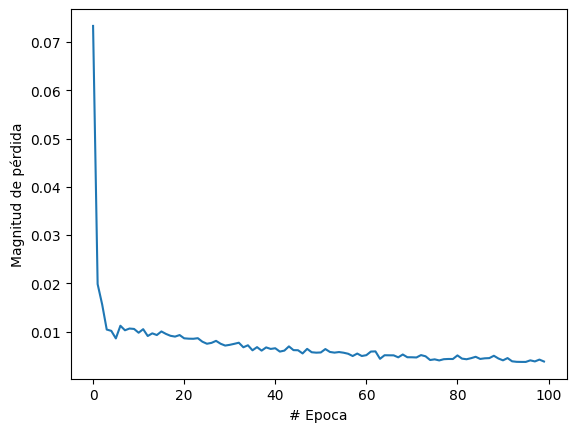

In [13]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(model.history.history["loss"])

In [14]:
predicted_values = model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted_values)  # Desnormalizar

3/3 [==============================] - 11s 107ms/step


##Evaluación del modelo

In [15]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(scaler.inverse_transform(y_test), predicted_values)
print(f"Error cuadrado medio: {mse}")

Error cuadrado medio: 96.40601942762738


In [16]:
rmse = np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), predicted_values))
print(f"Error cuadrado medio raíz: {rmse}")

Error cuadrado medio raíz: 9.818656701791106


In [17]:
from sklearn.metrics import r2_score

r2 = r2_score(scaler.inverse_transform(y_test), predicted_values)
print(f"Coeficiente de determinación (R^2): {r2}")

Coeficiente de determinación (R^2): 0.8342166819872268


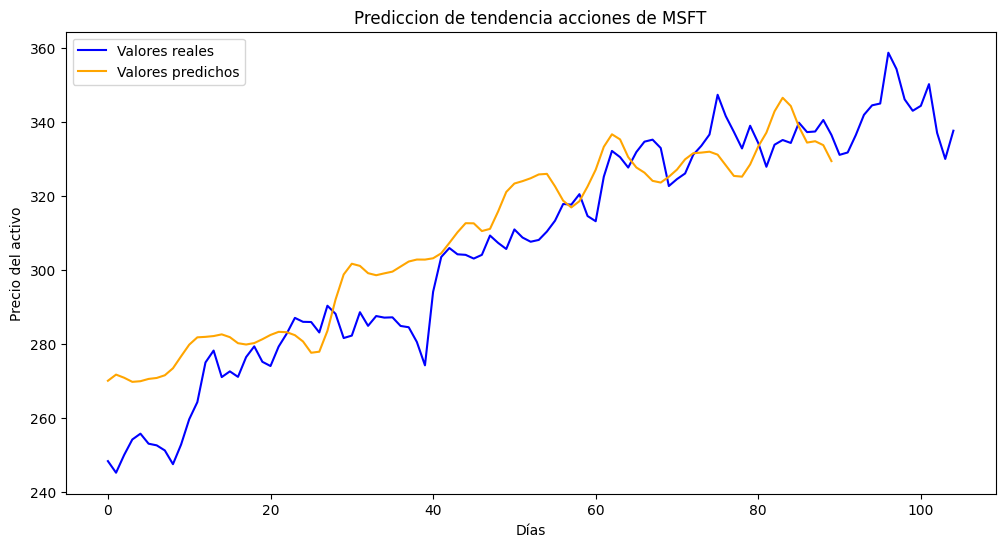

In [18]:
# Visualizar los resultados
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(test_data), label='Valores reales', color='blue')
plt.plot(predicted_values, label='Valores predichos', color='orange')
plt.legend()
plt.xlabel('Días')
plt.ylabel('Precio del activo')
plt.title("Prediccion de tendencia acciones de {t}".format(t=key))
plt.show()

1/1 [==============================] - 0s 185ms/step


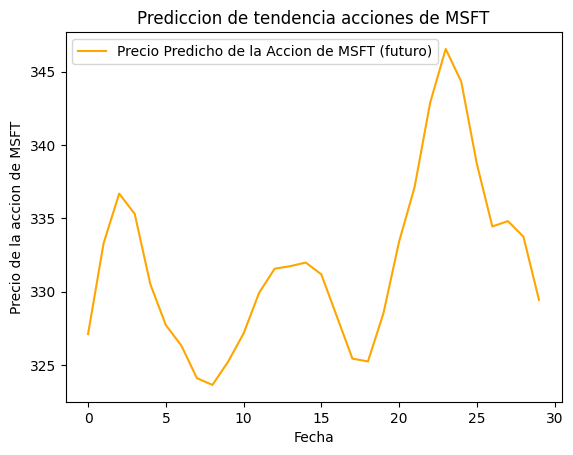

In [19]:
# Obtener las predicciones para los próximos 30 días
predicted_stock_price_future = model.predict(X_test[-30:])
predicted_stock_price_future = scaler.inverse_transform(predicted_stock_price_future)

# Graficar los valores reales y predichos
# plt.plot(real_stock_price, color = 'red', label = 'Precio Real de la Accion de {t}'.format(t=key))
# plt.plot(predicted_stock_price, color = 'blue', label = 'Precio Predicho de la Accion de {t}'.format(t=key))
plt.plot(predicted_stock_price_future, color = 'orange', label = 'Precio Predicho de la Accion de {t} (futuro)'.format(t=key))
plt.title("Prediccion de tendencia acciones de {t}".format(t=key))
plt.xlabel("Fecha")
plt.ylabel("Precio de la accion de {t}".format(t=key))
plt.legend()
plt.show()

In [20]:
# guardar modelo
model.save('RNN_model.h5')